In [1]:
DATA_DIR = '../../data/'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
import pandas as pd

Срок выполнения задания – до 10 апреля включительно.

Отчет высылается по почте Зуеву Кириллу на адрес  kir2207@list.ru

В качестве темы письма указать:  «КЛ ДЗ № 3, ФИО»

Отчет должен быть в виде отдельного текста, код программы включается как приложение.

# Задание E.
Составить (с использованием любого модуля морфоанализа) программу, выполняющую извлечение словосочетаний определенного вида из заданного русскоязычного текста. Выделение словосочетаний может базироваться на локальных высоковероятных синтаксических связях (см. слайд 50 Лекции  № 7). Программа выводит все словосочетания  заданного вида/ов, встречающиеся в обрабатываемом тексте. 
Рассмотреть несколько (2-5) грамматических образцов словосочетаний, например:
* именные словосочетания (NP), в которые входят  грамматически согласованные прилагательные и существительное (и, возможно, порядковые числительные или наречие,  например: первый детальный написанный план или более сложный образец: первый детально написанный план);
* именные словосочетания, включающие несколько существительных и прилагательные (зависимые существительные входят в родительном падеже, прилагательные согласованы с соответствующими существительными, например: легкий отблеск далекого заката);
* предложные словосочетания, в которые входят именные словосочетания одного из грамматических образцов (например: в тихом летнем парке);
* глагольные группы, состоящие из глагола в личной форме  и зависимой именной группы (например: увидел большой стеклянный шар).

Протестировать программу на нескольких небольших текстах разных жанров.

Отчет:  Описание грамматических образцов извлекаемых словосочетаний и стратегии (алгоритма) их выделения; составленная и примененная программа с комментариями, результаты ее тестирования.

# Определение лексем через Mystem

In [1]:
from pymystem3 import mystem

In [6]:
import pymystem3

In [8]:
pymystem3.__version__

'0.2.0'

In [6]:
mstm = mystem.Mystem()

Загрузка справочников для тегов mystem

In [7]:
mystem_dicts = pd.read_html('https://yandex.ru/dev/mystem/doc/grammemes-values-docpage/')
mystem_dicts = mystem_dicts[::2]

mystem_dicts_d = {k:mystem_dicts[idx] for idx, k in enumerate([
    'POS','Tense','Case','Number','Mood',
    'Fullness','Suprs','Person', 'Gender', 'Aspect',
    'Voice','Animacy', 'Transitivity','Other'
])}

In [8]:
def split_by_semisentences(txt):
    return [x.strip() for x in re.sub(r'[^\w\s\'\`]','|', txt).split('|') if x.strip()!='']

In [9]:
def split_by_word(txt):
    return [x.strip() for x in re.split(' ', txt) if re.match('\w', x)]

In [10]:
def construct_lexemes_mystem(txt, verb=False):
    lexemes = mstm.analyze(txt)
    lexemes = [lxm for lxm in lexemes if lxm['text'].strip()!='' and 'analysis' in lxm]
    
    new_lexemes = []
    for lxm in lexemes:
        anl = lxm['analysis']
        if len(anl)==0:
            if verb:
                print(f'No analysis for lexeme {lxm}')
            continue
        if len(anl)>1:
            if verb:
                print(f'More then 1 analysis for lexeme {lxm}')
        gr = anl[0]['gr']
        
        gr_const, gr_var = gr.split('=')[0], gr.split('=')[1].replace('(','').replace(')','')
        variants = [set(gr_const.split(',')+x.split(',')) for x in gr_var.split('|')] if gr_var!='' else [set(gr_const.split(','))]
        
        parsed_vars = []
        for var in variants:
            parsed_var = {}
            for x in var:
                for k,v in mystem_dicts_d.items():
                    if x in v[0].values:
                        parsed_var[k]=x
                        break
            parsed_var['mystem_view'] = var
            parsed_var['word'] = lxm['text']
            parsed_vars.append(parsed_var)
        new_lexemes.append(parsed_vars)
    
    return new_lexemes

# Определение грамматических образцов

## 1.
Именные словосочетания (NP), в которые входят  грамматически согласованные прилагательные и существительное (и, возможно, порядковые числительные или наречие,  например: первый детальный написанный план или более сложный образец: первый детально написанный план);

In [11]:
def is_quaziadj_noun_agree(adj, n):
    for var_adj in adj:
        for var_n in n:
            if var_adj['POS']=='ADV' and var_n['POS']=='S':
                return True
            
            # Является ли прилагательное прилагательным или хотя бы причастием
            is_adj_an_adj = (var_adj['POS'] in ['A','ANUM','APRO']) or (var_adj.get('POS')=='V' and var_adj.get('Mood')=='прич')
            # Является ли существительное существительным
            is_n_an_n = var_n['POS']=='S'
            # Совпадают ли прилагательное и существительное по роду (кроме случая местоимения-прилагательного и слов во мн. числе)
            check_gender = (var_adj['POS'] in ['APRO'] or var_n['Number']=='мн') or ('Gender' in var_n and var_adj.get('Gender')==var_n.get('Gender'))
            # Проверка совпадения числа прилагательного и существительного
            check_number = var_adj.get('Number')==var_n.get('Number')
            # Проверка совпадения падежей
            check_case = 'Case' in var_n and var_adj.get('Case')==var_n.get('Case')
            
            if is_adj_an_adj and is_n_an_n and check_gender and check_number and check_case:
                return True
    return False

In [12]:
def find_NP1(txt):
    lexemes = construct_lexemes_mystem(txt)
    groups = []
    nouns = [idx for idx, lxm in enumerate(lexemes) if idx>0 and any([var['POS']=='S' for var in lxm])]
    for noun_idx in nouns:
        noun = lexemes[noun_idx]
        first_adj_idx = noun_idx
        while True:
            new_first_adj_idx = first_adj_idx-1
            if new_first_adj_idx<0:
                break

            new_first_adj = lexemes[new_first_adj_idx]

            if is_quaziadj_noun_agree(new_first_adj, noun): # число род падеж
                first_adj_idx -= 1
            else:
                break
        if first_adj_idx==noun_idx:
            continue

        groups.append(f' '.join([x[0]['word'] for x in lexemes[first_adj_idx:noun_idx+1]]))
    return groups

In [13]:
txt = 'хоть сейчас был не самый подходящий момент демонстрировать свои познания'

In [14]:
find_NP1(txt)

['самый подходящий момент', 'свои познания']

## 2.
именные словосочетания, включающие несколько существительных и прилагательные (зависимые существительные входят в родительном падеже, прилагательные согласованы с соответствующими существительными, например: легкий отблеск далекого заката);

In [15]:
from itertools import chain, combinations, permutations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [16]:
def select_posible_nouns(txt):
    return [[t for t in lxm if t['POS']=='S'] for lxm in construct_lexemes_mystem(txt) if any([t['POS']=='S' for t in lxm])]

In [17]:
def find_NP2(txt):
    # Выбираем все именные словосочетания первого типа
    lexemes = construct_lexemes_mystem(txt)
    groups = find_NP1(txt)

    # Ищем комбинации из найденных словосочетаний, которые встречаются в исходном тексте
    posible_np2s = []
    for comb in powerset(groups):
        if len(comb)<2:
            continue
        for comb_ in permutations(comb):
            if ' '.join(comb_) in txt:
                posible_np2s.append(comb_)
    
    # Фильтруем найденные словосочетания, так, чтобы одно из существительных все существительные кроме одного в них были в род. падеже
    real_np2s = []
    for comb in posible_np2s:
        pos_nouns = [select_posible_nouns(c)[0] for c in comb]
        perms = permutations(pos_nouns)
        for perm in perms:
            is_first_part_not_gen = any([t['Case']!='род' for t in perm[0]]) #есть ли в первом словосочетании сущ. не в род. падеже
            is_second_part_gen = all([any([t['Case']=='род' for t in lxm]) for lxm in perm[1:]]) # стоят ли все оставшиеся сущ. в род. падеже 
            
            if  is_first_part_not_gen and is_second_part_gen:
                real_np2s.append(comb)
                break
    # Убираем словосочетания, если они входят в более общие словосочетания
    real_np2s = [comb for comb in real_np2s if not any([' '.join(comb) in ' '.join(comb_) for comb_ in real_np2s if comb_!=comb]) ]
    return [' '.join(np2) for np2 in real_np2s]

In [18]:
txt = 'легкий отблеск далекого заката быстро потускневшего неба'

In [19]:
txt = 'легким отблеском далекого заката быстро потускневшего неба'

In [20]:
find_NP2(txt)

['легким отблеском далекого заката быстро потускневшего неба']

## 3.
предложные словосочетания, в которые входят именные словосочетания одного из грамматических образцов (например: в тихом летнем парке);

In [21]:
def find_preposition_phrases(txt):
    # ищем именные словосочетания
    nps = find_NP1(txt)+find_NP2(txt)
    # оставляем только наиболее общие словосочетания
    nps = [np for np in nps if not any([np_.startswith(np) for np_ in nps if np_!=np])]
    # ищем индексы начала и конца именных словосочетаний в тесте
    places_for_prep = [match.span() for np in nps for match in re.finditer(np, txt)]
    
    # проверяем найденные именные словосочетания, стоит ли перед ними предлог
    preps = []
    for idx, pl in enumerate(places_for_prep):
        start_lxm, stop_lxm = pl[0], pl[1]

        lexemes = construct_lexemes_mystem(txt[:stop_lxm]) # ищем лексемы включая именное словосочетание
        lexemes = lexemes[:-len(construct_lexemes_mystem(txt[start_lxm:stop_lxm]))] # исключаем именное словосочетание из анализа
        if len(lexemes)==0:
            continue
        last_lxm = lexemes[-1]
        if any([t['POS']=='PR' for t in last_lxm]):
            preps.append(last_lxm[0]['word']+' '+txt[start_lxm:stop_lxm])
    return preps

In [22]:
txt = 'в тихом летнем парке и в жаркой далёкой пустыне белых огней'

In [23]:
find_preposition_phrases(txt)

['в тихом летнем парке', 'в жаркой далёкой пустыне белых огней']

## 4.
глагольные группы, состоящие из глагола в личной форме  и зависимой именной группы (например: увидел большой стеклянный шар).

In [24]:
def find_verb_phrases(txt):
    # Находим именные словосочетания
    nps = find_NP1(txt) + find_NP2(txt)
    # Убираем NP1 входящие в NP2
    nps = [np for np in nps if not any([np_.startswith(np) for np_ in nps if np_!=np])]
    # Проверяем, что в словосочетании есть существительное в вин. падеже
    nps = [np for np in nps if any([t['POS']=='S' and t['Case']=='вин' for lxm in construct_lexemes_mystem(np) for t in lxm])]
    
    # ищем индексы начала и конца именных словосочетаний в тесте
    places_for_verb = [match.span() for np in nps for match in re.finditer(np, txt)]
    
    # проверяем найденные именные словосочетания, стоит ли перед ними предлог
    vps = []
    for idx, pl in enumerate(places_for_verb):
        start_lxm, stop_lxm = pl[0], pl[1]

        lexemes = construct_lexemes_mystem(txt[start_lxm:stop_lxm])

        # проверяем лексему до начала именного словосочетания
        lexemes_before = construct_lexemes_mystem(txt[:start_lxm]) # ищем лексемы
        if len(lexemes_before)>0:
            last_lxm = lexemes_before[-1]
            if any([t['POS']=='V' and t['Mood'] in ['инф', 'изъяв', 'пов'] for t in last_lxm]):
                vps.append(last_lxm[0]['word']+' '+txt[start_lxm:stop_lxm])
                continue

        # проверяем лексему после начала именного словосочетания
#        lexemes_after = construct_lexemes_mystem(txt[stop_lxm:]) # ищем лексемы
#        if len(lexemes_after)>0:
#            first_lxm = lexemes_after[0]
#            if any([t['POS']=='V' and t['Mood'] in ['инф', 'изъяв', 'пов'] for t in first_lxm]):
#                vps.append(txt[start_lxm:stop_lxm]+' '+first_lxm[0]['word'])
#                continue

    return vps

In [25]:
txt = 'увидел большой стеклянный шар красного золота'

In [26]:
find_verb_phrases(txt)

['увидел большой стеклянный шар красного золота']

# Анализ текстов

In [27]:
def find_pattern(long_text, ptrn):
    txts = split_by_semisentences(long_text)
    ptrns = [(txts[idx], x) for idx, x in [(idx, ptrn(txt)) for idx, txt in enumerate(txts)] if len(x)>0]
    return ptrns

In [28]:
def print_pattern(ptrns, n_lim=5):
    n_lim = min(n_lim, len(ptrns)) if n_lim is not None else len(ptrns)
    print(f'Total N phrases: {len(ptrns)}')
    print(f'Mean length of phrases: {np.mean([len(x.split(" ")) for p in ptrns for x in p[1]]):.2f}')
    print('Examples:')
    for idx in range(n_lim):
        print(f'"{ptrns[idx][0]}" => "'+ '", "'.join(ptrns[idx][1])+'"')

In [29]:
def analyze_text(txt, n_lim=5, verb=True, genre=None, title=None):
    stat = {'genre':genre, 'title':title}
    stat['n_sentences'] = len(split_by_semisentences(txt))
    for name, ptrn in [('NP1',find_NP1), ('NP2',find_NP2), ('Preposition Phrases', find_preposition_phrases), ('Verb Phrases', find_verb_phrases)]:
        ptrns = find_pattern(txt, ptrn)
        stat[f'{name}_count'] = len(ptrns)
        stat[f'{name}_mean_length'] = np.mean([len(x.split(' ')) for p in ptrns for x in p[1]])
        
        if verb:
            print(name)
            print_pattern(ptrns, n_lim=n_lim)
            print('===================================')
            print()
    return stat

In [30]:
stats = []

## Художественный текст

### Алиса в Стране Чудес Глава 1

In [31]:
with open(DATA_DIR+'art_alice_full_text.txt', 'r') as f:
    alice_txt = f.read()

In [32]:
alice_txt_by_chapter = {idx:s.strip() for idx, s in enumerate([s for s in re.split('Глава.*\n\n\n', alice_txt) if len(s)>0])}
txt = alice_txt_by_chapter[0]

In [33]:
stat = analyze_text(alice_txt_by_chapter[0], genre='art', title='alice p1')
stats.append(stat)

NP1
Total N phrases: 72
Mean length of phrases: 2.17
Examples:
"Вдруг мимо пробежал кролик с красными глазами" => "красными глазами"
"однако в тот миг все казалось ей вполне естественным" => "тот миг"
"когда Кролик вдруг вынул часы из жилетного кармана и" => "жилетного кармана"
"да еще с жилетным карманом в придачу" => "жилетным карманом"
"словно в глубокий колодец" => "глубокий колодец"

NP2
Total N phrases: 1
Mean length of phrases: 4.00
Examples:
"Однако на этом пузырьке никаких пометок не было" => "этом пузырьке никаких пометок"

Preposition Phrases
Total N phrases: 29
Mean length of phrases: 3.23
Examples:
"Вдруг мимо пробежал кролик с красными глазами" => "с красными глазами"
"однако в тот миг все казалось ей вполне естественным" => "в тот миг"
"когда Кролик вдруг вынул часы из жилетного кармана и" => "из жилетного кармана"
"да еще с жилетным карманом в придачу" => "с жилетным карманом"
"словно в глубокий колодец" => "в глубокий колодец"

Verb Phrases
Total N phrases: 9
Mean leng

### "Крыжовник", Чехов

In [34]:
with open(DATA_DIR+'art_checkhov_gooseberry.txt','r') as f:
    goosb_txt = f.read()

In [35]:
stat = analyze_text(goosb_txt, genre='art', title="Gooseberry")
stats.append(stat)

NP1
Total N phrases: 193
Mean length of phrases: 2.12
Examples:
"Еще с раннего утра всё небо обложили дождевые тучи" => "раннего утра", "всё небо", "дождевые тучи"
"как бывает в серые пасмурные дни" => "серые пасмурные дни"
"Ветеринарный врач Иван Иваныч и учитель гимназии Буркин уже утомились идти" => "Ветеринарный врач"
"Далеко впереди еле были видны ветряные мельницы села Мироносицкого" => "ветряные мельницы"
"зеленые ивы" => "зеленые ивы"

NP2
Total N phrases: 1
Mean length of phrases: 4.00
Examples:
"Еще с раннего утра всё небо обложили дождевые тучи" => "раннего утра всё небо"

Preposition Phrases
Total N phrases: 76
Mean length of phrases: 3.05
Examples:
"Еще с раннего утра всё небо обложили дождевые тучи" => "с раннего утра всё небо"
"как бывает в серые пасмурные дни" => "в серые пасмурные дни"
"который издали похож на ползущую гусеницу" => "на ползущую гусеницу"
"а в ясную погоду оттуда бывает виден даже город" => "в ясную погоду"
"в тихую погоду" => "в тихую погоду"

Verb Phr

### "Трудно быть богом", Стругацкие

In [36]:
with open(DATA_DIR+'art_strugatskie_god.txt','r') as f:
    gods_txt = f.read()

In [37]:
stat = analyze_text(gods_txt, genre='art', title="Hard to be a god")
stats.append(stat)

NP1
Total N phrases: 397
Mean length of phrases: 2.18
Examples:
"седьмую по счету и последнюю на этой дороге" => "этой дороге"
"Хваленый хамахарский жеребец" => "Хваленый хамахарский жеребец"
"взятый у дона Тамэо за карточный долг" => "карточный долг"
"оказался сущим барахлом" => "сущим барахлом"
"вихляющейся рысью" => "вихляющейся рысью"

NP2
Total N phrases: 14
Mean length of phrases: 4.29
Examples:
"в лучших традициях серых казарм" => "лучших традициях серых казарм"
"У коновязи перед корчмой топтались оседланные кони серого патруля" => "оседланные кони серого патруля"
"Благородному дону счастливого пути" => "Благородному дону счастливого пути"
"что триста лет назад железные роты имперского маршала Тоца" => "назад железные роты имперского маршала"
"а разухабистые егеря барона Пампы жарили на редких полянах ворованных быков" => "редких полянах ворованных быков"

Preposition Phrases
Total N phrases: 118
Mean length of phrases: 3.28
Examples:
"седьмую по счету и последнюю на этой дороге

## Научно-технический текст

### "ПОСОБИЕ ПО НАПИСАНИЮ РАЗНОГО РОДА ДЕЛОВЫХ ТЕКСТОВ"
https://www.iis.nsk.su/files/articles/sbor_kas_16_nesgovorova.pdf

In [38]:
with open(DATA_DIR+'doc_how_to_business_text.txt','r') as f:
    how_to_buis_txt = f.read()

In [39]:
def beautify_str(s):
    s = re.sub(r'Рис\. \d+\n+', '', s)
    s = re.sub('[^\.?;\n](\n)[^\n]', ' ', s)
    return s

In [40]:
how_to_buis_txt = beautify_str(how_to_buis_txt)

In [41]:
stat = analyze_text(how_to_buis_txt, genre='doc', title='How to Write Buisiness Texts')
stats.append(stat)

NP1
Total N phrases: 346
Mean length of phrases: 2.16
Examples:
"Научным сотрудникам" => "Научным сотрудникам"
"инженерам и людям других творческих специальностей в своей профессиональной деятельности не обойтись без оформления ряда документов" => "других творческих специальностей", "своей профессиональной деятельности"
"разного рода описания" => "разного рода"
"деловые письма" => "деловые письма"
"При этом надо учитывать особенности деловой письменной речи" => "деловой письменной речи"

NP2
Total N phrases: 31
Mean length of phrases: 4.35
Examples:
"и следовало бы изучить особенности деловой разновидности родного русского языка" => "деловой разновидности родного русского языка"
"В предлагаемом пособии за основу взят не традиционный курс русского языка" => "традиционный курс русского языка"
"изучает письменную форму официальноделового общения с целью ее унификации и нормализации" => "письменную форму официальноделового общения"
"их разработке и применении или о моделировании с их помощ

### Статьи N+1

In [42]:
with open(DATA_DIR+'doc_nplus1.txt','r') as f:
    nplus1_txt = f.read()

In [43]:
stat = analyze_text(nplus1_txt, genre='doc', title="NPlus1 texts")
stats.append(stat)

NP1
Total N phrases: 107
Mean length of phrases: 2.16
Examples:
"Геофизики разработали простой и не требовательный к вычислительным ресурсам программный инструмент" => "вычислительным ресурсам", "программный инструмент"
"который позволяет идентифицировать гравитационные волны" => "гравитационные волны"
"Поскольку гравитационные волны распространяются со скоростью света" => "гравитационные волны"
"новый метод поможет детектировать землетрясения намного раньше" => "новый метод"
"чем к сейсмостанциям придут обычные сейсмические волны" => "обычные сейсмические волны"

NP2
Total N phrases: 11
Mean length of phrases: 4.18
Examples:
"но для создания новых систем раннего оповещения о сейсмических толчках необходимо создать новые более чувствительные гравиметры и инфраструктуру" => "новых систем раннего оповещения"
"Физики измерили тонкое расщепление и лэмбовский сдвиг энергетических состояний атома антиводорода" => "лэмбовский сдвиг энергетических состояний"
"однако на больших масштабах нет ни

### Math importance

In [44]:
with open(DATA_DIR+'doc_math_importance.txt','r') as f:
    math_imp_txt = f.read()

In [45]:
stat = analyze_text(math_imp_txt, genre='doc', title="Math importance")
stats.append(stat)

NP1
Total N phrases: 85
Mean length of phrases: 2.20
Examples:
"Основные задачи изучения математики как науку" => "Основные задачи"
"являются оперирующими чистыми абстракциями" => "оперирующими чистыми абстракциями"
"отделёнными от реального мира" => "реального мира"
"Воспитание
математической культуры" => "математической культуры"
"развитие логического и
алгоритмического мышления" => "алгоритмического мышления"

NP2
Total N phrases: 3
Mean length of phrases: 4.33
Examples:
"Но теории и методы созданные в рамках
таких формализованных систем могут найти неожиданное
применение в различных отраслях научного знания" => "различных отраслях научного знания"
"второй вид полной формализации" => "второй вид полной формализации"
"их
существенная зависимость от случайных природных
факторов обуславливают вероятностный характер многих производственных процессов" => "вероятностный характер многих производственных процессов"

Preposition Phrases
Total N phrases: 16
Mean length of phrases: 3.35
Exampl

# Статистика по всем текстам

In [46]:
stat_ds = pd.concat([pd.Series(x) for x in stats],1).T
for f in stat_ds.columns:
    try: stat_ds[f] = stat_ds[f].astype(float)
    except: pass

In [47]:
for f in [f for f in stat_ds if f.endswith('_count')]:
    stat_ds[f.replace('_count', '_ratio')] = stat_ds[f]/stat_ds['n_sentences']*100
    stat_ds = stat_ds.drop(f,1)

In [48]:
cols_map = {
 'title': 'Название',
 'n_sentences': 'Кол-во предложений',
 'NP1_mean_length': 'Средняя длина именных словосочетаний из одного сущ.',
 'NP2_mean_length': 'Средняя длина именных словосочетаний из неск. сущ.',
 'Preposition Phrases_mean_length': 'Средняя длина предложных словосочетаний',
 'Verb Phrases_mean_length': 'Средняя длина глагольных словосочетаний',
 'NP1_ratio': 'Процент предл. с именными сл-ми из одного сущ.',
 'NP2_ratio': 'Процент предл. с именными сл-ми из неск. сущ.',
 'Preposition Phrases_ratio': 'Процент предл. с предложными сл-ми',
 'Verb Phrases_ratio': 'Процент предл. с глагольными сл-ми',
}

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


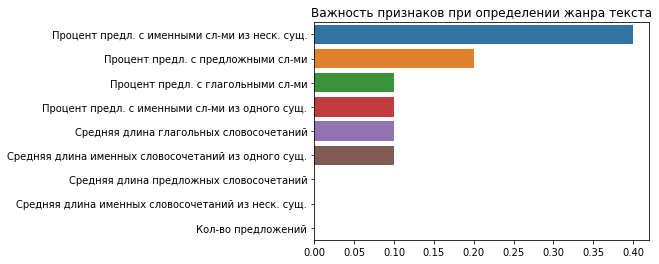

In [49]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(stat_ds.drop(['genre','title'],1), stat_ds['genre'])
s = pd.Series(rf.feature_importances_, index=stat_ds.drop(['genre','title'],1).columns).sort_values(ascending=False)

plt.title('Важность признаков при определении жанра текста')
sns.barplot(x=s.values, y=s.index)
plt.yticks(plt.yticks()[0], [cols_map[x.get_text()] for x in plt.yticks()[1]])
plt.show()

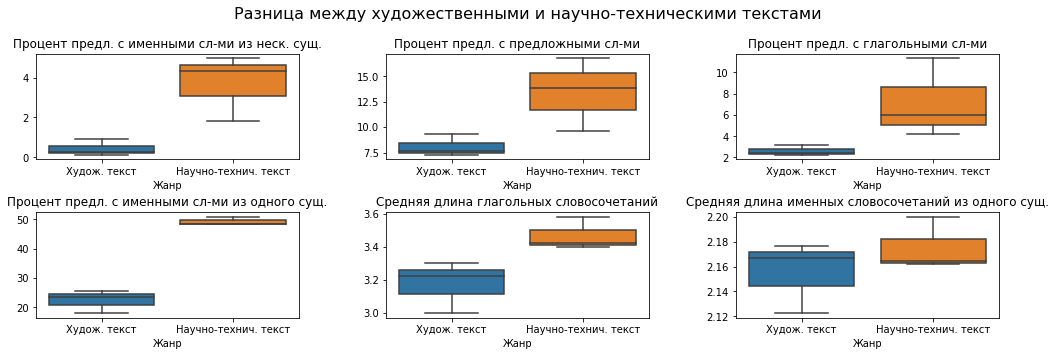

In [50]:
plt.figure(figsize=(15,5))
for idx, f in enumerate(s.index[:6]):
    plt.subplot(2,3,idx+1)
    sns.boxplot(x='genre', y=f, data=stat_ds)
    plt.title(cols_map[f])
    plt.ylabel('')
    plt.xlabel('Жанр')
    plt.xticks(plt.xticks()[0], [{'art':'Худож. текст', 'doc':'Научно-технич. текст'}[x.get_text()] for x in plt.xticks()[1]])
plt.tight_layout()
plt.suptitle('Разница между художественными и научно-техническими текстами', size=16)
plt.subplots_adjust(top=0.85,)
plt.show()